In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

2024-07-16 20:16:42.959476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 20:16:42.959644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 20:16:43.094435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define dataset path and parameters
dataset_path = '/kaggle/input/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Fruits'
img_height, img_width = 224, 224
batch_size = 32
num_classes = 2  # Assuming 2 classes (folders)

class_names = ['FreshBanana', 'RottenBanana']  # Replace with actual class folder names

In [3]:
import shutil
import os
from PIL import Image

def copy_directory(src, dst):
    for root, dirs, files in os.walk(src):
        for file in files:
            file_path = os.path.join(root, file)
            new_path = os.path.join(dst, os.path.relpath(file_path, src))
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
            if not os.path.exists(new_path):
                shutil.copy(file_path, new_path)
            else:
                print(f"File {new_path} already exists, skipping...")

# Replace these with the paths to your original and new dataset directories
original_fruits_directory = '/kaggle/input/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Fruits'
new_fruits_directory = '/kaggle/working/c'

# Ensure base directory is created
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

ensure_directory(new_fruits_directory)


In [4]:
copy_directory(original_fruits_directory, new_fruits_directory)

In [5]:
# Function to validate and convert images
def clean_and_convert_dataset(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_valid_image(file_path):
                print(f"Removing invalid image file: {file_path}")
                os.remove(file_path)
            else:
                try:
                    img = Image.open(file_path)
                    rgb_img = img.convert('RGB')
                    new_file_path = os.path.splitext(file_path)[0] + '.jpg'
                    rgb_img.save(new_file_path, 'JPEG')
                    if file_path != new_file_path:
                        os.remove(file_path)
                except Exception as e:
                    print(f"Error converting file {file_path}: {e}")

def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verify that it is an image
        return True
    except (IOError, SyntaxError) as e:
        return False

# Clean and convert the copied directories
clean_and_convert_dataset(new_fruits_directory)


In [6]:
dataset_path= new_fruits_directory

# Prepare lists for image file paths and labels
file_paths = []
labels = []

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)
    file_paths.extend([os.path.join(class_path, img) for img in images])
    labels.extend([class_name] * len(images))

# Convert labels to numerical values
label_to_index = {name: index for index, name in enumerate(class_names)}
numeric_labels = [label_to_index[label] for label in labels]

In [7]:
# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    file_paths, numeric_labels, test_size=0.3, random_state=42, stratify=numeric_labels)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

print(f"Number of training examples: {len(train_files)}")
print(f"Number of validation examples: {len(val_files)}")
print(f"Number of test examples: {len(test_files)}")

# Create TensorFlow datasets
def load_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

train_ds1 = tf.data.Dataset.from_tensor_slices((train_files, train_labels)).map(load_image).batch(batch_size)
val_ds1 = tf.data.Dataset.from_tensor_slices((val_files, val_labels)).map(load_image).batch(batch_size)
test_ds1 = tf.data.Dataset.from_tensor_slices((test_files, test_labels)).map(load_image).batch(batch_size)


Number of training examples: 709
Number of validation examples: 152
Number of test examples: 152


In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),

])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Apply data augmentation to training dataset
train_ds2 = train_ds1.map(lambda x, y: (data_augmentation(x, training=True), y))

# Preprocess and scale images
train_ds = train_ds2.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds1.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input(x), y))


# MobileNetV2

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])


model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model and save history
history = model.fit(train_ds, batch_size=32,epochs=100,validation_data=val_ds, callbacks=[early_stopping])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
 3/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4323 - loss: 0.9525 

I0000 00:00:1720394089.443106     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 910ms/step - accuracy: 0.6145 - loss: 0.7266 - val_accuracy: 0.9276 - val_loss: 0.2278
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - accuracy: 0.9459 - loss: 0.1845 - val_accuracy: 0.9803 - val_loss: 0.1182
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - accuracy: 0.9812 - loss: 0.1039 - val_accuracy: 0.9868 - val_loss: 0.0813
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 447ms/step - accuracy: 0.9865 - loss: 0.0698 - val_accuracy: 0.9868 - val_loss: 0.0605
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.9866 - loss: 0.0593 - val_accuracy: 0.9934 - val_loss: 0.0478
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - accuracy: 0.9962 - loss: 0.0420 - val_accuracy: 0.9934 - val_loss: 0.0390
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step - accuracy: 0.9919 - loss: 0.0390 - val_accuracy: 0.9934 - val_loss: 0.0368
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.9882 - loss: 0.0398 - val_accuracy

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0014
Test Accuracy: 1.0
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

 FreshBanana     1.0000    1.0000    1.0000        66
RottenBanana     1.0000    1.0000    1.0000        86

    accuracy                         1.0000       152
   macro avg     1.0000    1.0000    1.0000       152
weighted avg     1.0000    1.0000    1.0000       152



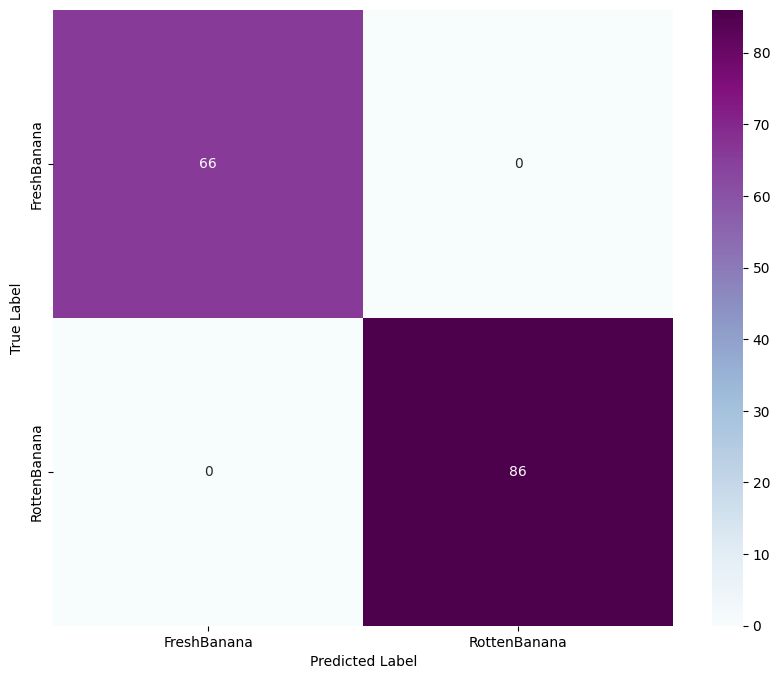

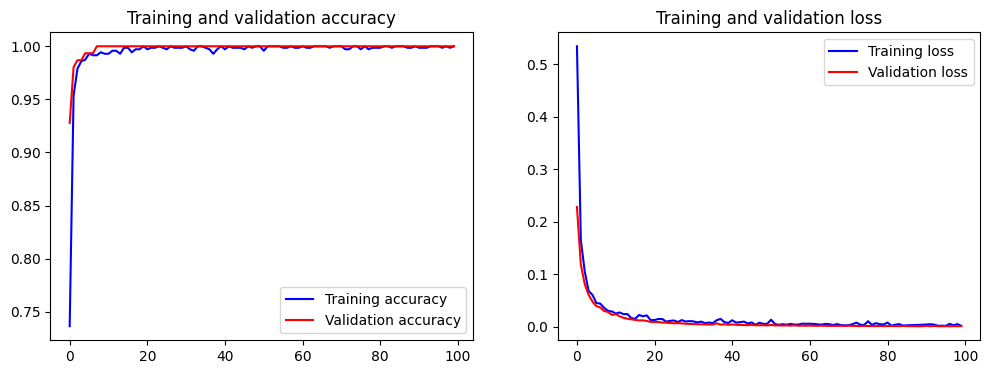

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# ResNet50

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential



# Preprocess input images for VGG16
def preprocess_input_resnet(x):
    x = tf.keras.applications.resnet.preprocess_input(x)
    return x

train_ds = train_ds2.map(lambda x, y: (preprocess_input_resnet(x), y))

val_ds = val_ds1.map(lambda x, y: (preprocess_input_resnet(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input_resnet(x), y))



# Load ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add layers on top of the base model
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

# Create the model
model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save history
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
 4/23 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7669 - loss: 0.4547

W0000 00:00:1720395316.726350     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8950 - loss: 0.2597

W0000 00:00:1720395332.283160     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720395336.608813     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 919ms/step - accuracy: 0.8974 - loss: 0.2550 - val_accuracy: 1.0000 - val_loss: 0.0300
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step - accuracy: 0.9886 - loss: 0.0275 - val_accuracy: 1.0000 - val_loss: 0.0177
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - accuracy: 0.9986 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 471ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 464ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 467ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 6.6113e-05
Test Accuracy: 1.0
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

 FreshBanana     1.0000    1.0000    1.0000        66
RottenBanana     1.0000    1.0000    1.0000        86

    accuracy                         1.0000       152
   macro avg     1.0000    1.0000    1.0000       152
weighted avg     1.0000    1.0000    1.0000       152



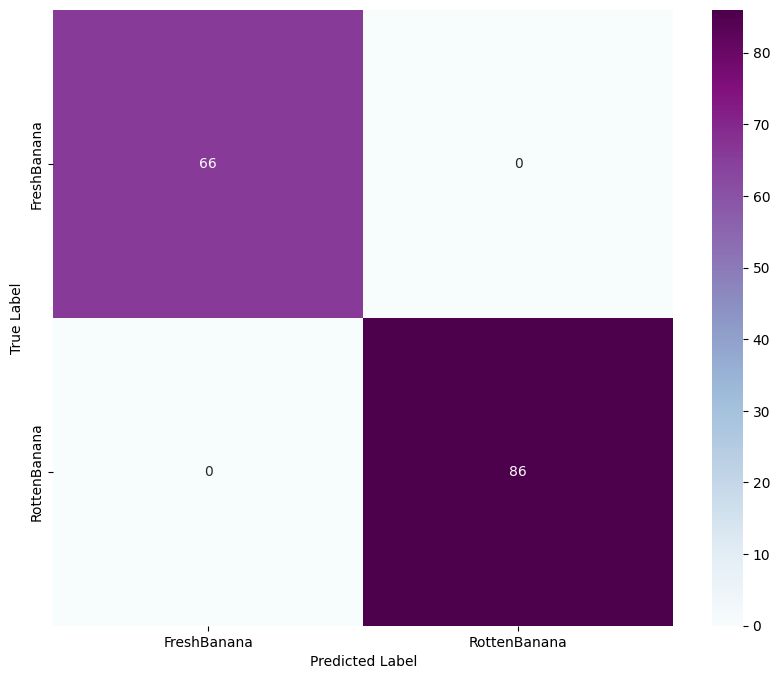

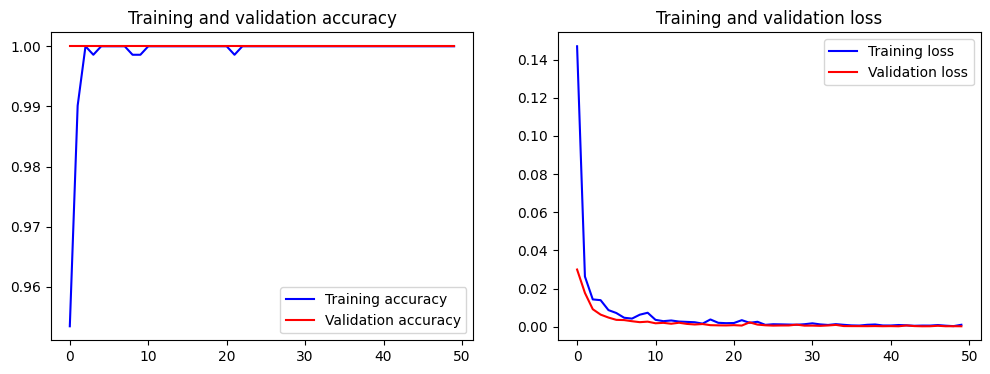

In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# VGG16

In [16]:
from tensorflow.keras.applications import VGG16

# Preprocess input images for VGG16
def preprocess_input_vgg(x):
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x

train_ds = train_ds2.map(lambda x, y: (preprocess_input_vgg(x), y))

val_ds = val_ds1.map(lambda x, y: (preprocess_input_vgg(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input_vgg(x), y))


# Assuming you have defined img_height, img_width, num_classes, train_ds, and val_ds appropriately

# Load VGG16 model with pre-trained ImageNet weights
base_model = VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add layers on top of the base model
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

# Create the model
model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save history
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


2024-07-07 23:45:08.344646: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-07-07 23:45:08.344723: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-07-07 23:45:08.344763: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-07-07 23:45:08.344776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-07-07 23:45:08.344787: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-07-07 23:45:08.344798: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-07-07 23:45:08.344808: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-07-07 23:45:08.344819: E external/local_xla/xla/se

22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6257 - loss: 4.9523

2024-07-07 23:45:31.819904: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.09291, expected 2.38321
2024-07-07 23:45:31.819962: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.88251, expected 5.1728
2024-07-07 23:45:31.819971: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.48389, expected 4.77418
2024-07-07 23:45:31.819979: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.23066, expected 4.52095
2024-07-07 23:45:31.819987: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.78972, expected 5.08001
2024-07-07 23:45:31.819995: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.97856, expected 4.26885
2024-07-07 23:45:31.820003: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.36704, expected 3.65734
2024-07-07 23:45:31.820011: 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.6273 - loss: 40.7751

2024-07-07 23:45:37.281784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50188: 2.79675, expected 2.40555
2024-07-07 23:45:37.281847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50357: 2.77153, expected 2.38033
2024-07-07 23:45:37.281857: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50399: 2.10715, expected 1.71595
2024-07-07 23:45:37.281888: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 55327: 2.85302, expected 2.46182
2024-07-07 23:45:37.282689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200704: 4.41732, expected 3.71194
2024-07-07 23:45:37.282724: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200705: 5.86452, expected 5.15914
2024-07-07 23:45:37.282747: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200706: 5.41314, expected 4.70776
2024-07-07 23:45:37.2827

23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6288 - loss: 73.6126 - val_accuracy: 0.8026 - val_loss: 1.6426
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - accuracy: 0.7903 - loss: 218.8108 - val_accuracy: 0.7895 - val_loss: 1.5315
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.7407 - loss: 28.9785 - val_accuracy: 0.7237 - val_loss: 3.3871
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 467ms/step - accuracy: 0.7871 - loss: 29.2230 - val_accuracy: 0.7895 - val_loss: 2.0086
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.7961 - loss: 1.3416 - val_accuracy: 0.7961 - val_loss: 1.4439
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.8079 - loss: 5.8315 - val_accuracy: 0.7961 - val_loss: 1.4112
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.7024 - loss: 116.3315 - val_accuracy: 0.7829 - val_loss: 1.5586
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.7572 - loss: 78.4001 - val_acc

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7558 - loss: 1.3120
Test Accuracy: 0.7828947305679321
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
              precision    recall  f1-score   support

 FreshBanana     0.8837    0.5758    0.6972        66
RottenBanana     0.7431    0.9419    0.8308        86

    accuracy                         0.7829       152
   macro avg     0.8134    0.7588    0.7640       152
weighted avg     0.8042    0.7829    0.7728       152



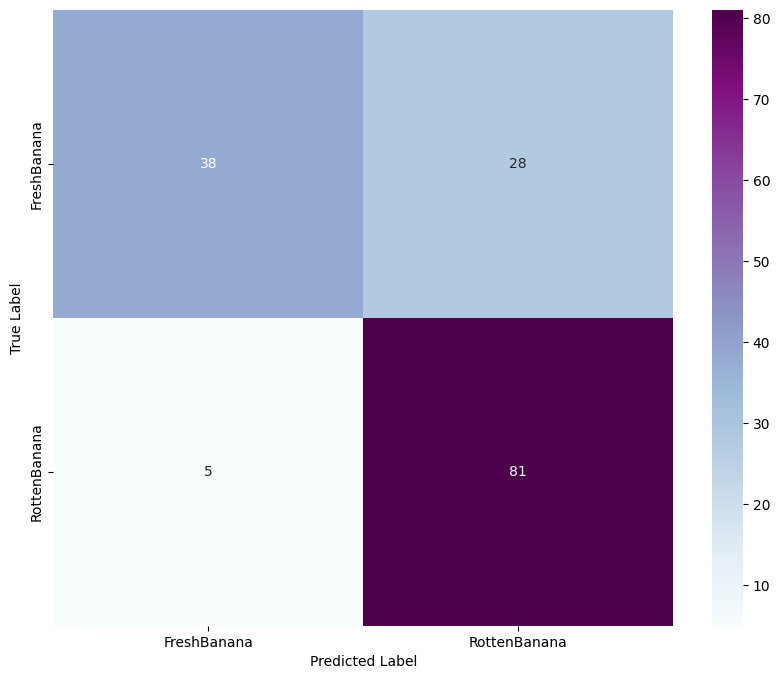

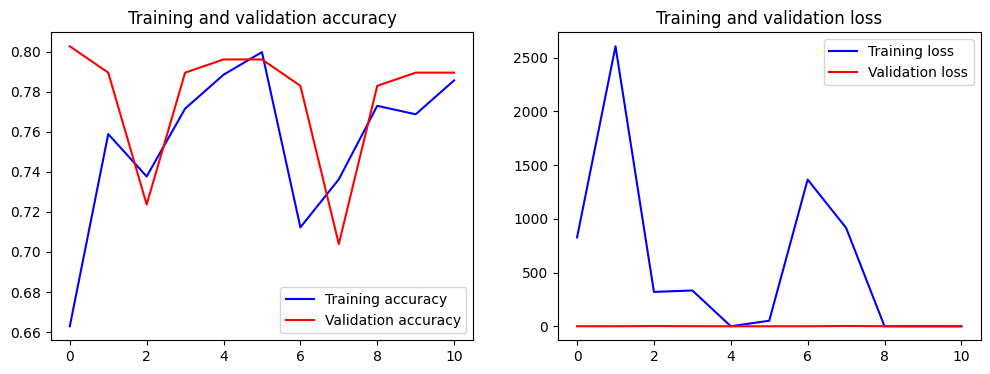

In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

In [18]:
# Unfreeze some layers of ResNet50 for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 563ms/step - accuracy: 0.8122 - loss: 1.4330 - val_accuracy: 0.9145 - val_loss: 0.3651
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 0.9744 - loss: 0.1016 - val_accuracy: 0.9934 - val_loss: 0.0277
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 464ms/step - accuracy: 0.9804 - loss: 3.7597 - val_accuracy: 0.9803 - val_loss: 0.0399
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 467ms/step - accuracy: 0.9808 - loss: 402.2702 - val_accuracy: 0.9803 - val_loss: 0.1854
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 467ms/step - accuracy: 0.9896 - loss: 96.1214 - val_accuracy: 0.9737 - val_loss: 0.0520
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step - accuracy: 0.9817 - loss: 0.0460 - val_accuracy: 0.9474 - val_loss: 0.1477
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 469ms/step - accuracy: 0.9816 - loss: 5.9638 - val_accuracy: 0.9474 - val_loss: 0.1589


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 9.5366e-04
Test Accuracy: 1.0
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
              precision    recall  f1-score   support

 FreshBanana     1.0000    1.0000    1.0000        66
RottenBanana     1.0000    1.0000    1.0000        86

    accuracy                         1.0000       152
   macro avg     1.0000    1.0000    1.0000       152
weighted avg     1.0000    1.0000    1.0000       152



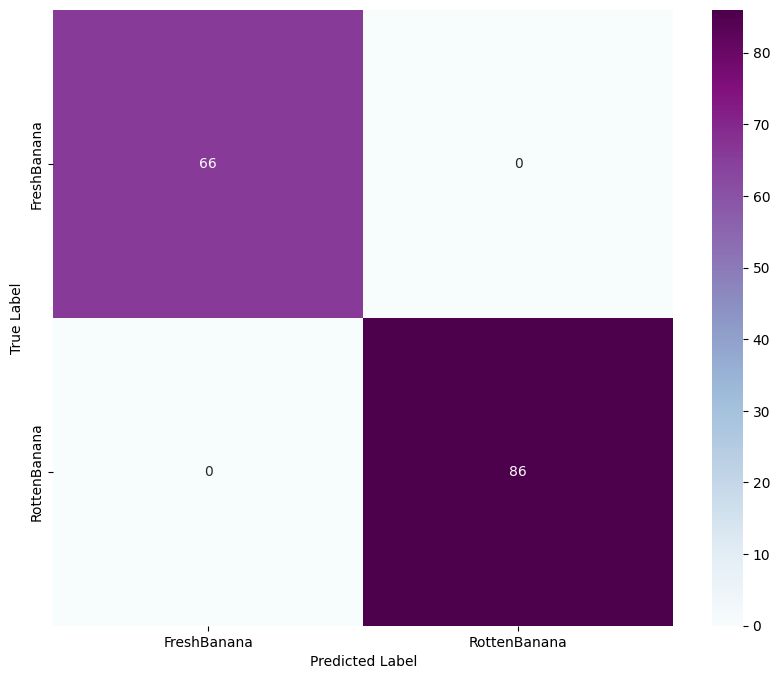

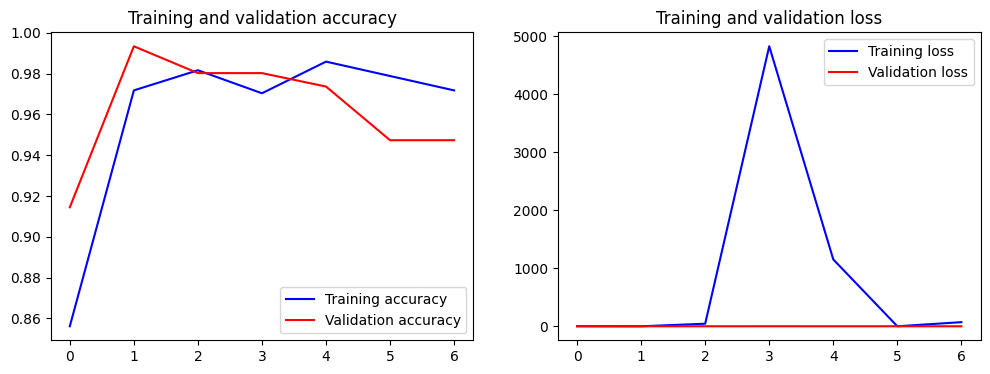

In [19]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# EfficientNetB0

In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Preprocess input images for EfficientNet
def preprocess_input_efficientnet(x):
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return x

train_ds = train_ds2.map(lambda x, y: (preprocess_input_efficientnet(x), y))
val_ds = val_ds1.map(lambda x, y: (preprocess_input_efficientnet(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input_efficientnet(x), y))

# Load EfficientNetB7 model with pre-trained ImageNet weights
base_model = EfficientNetB0(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add layers on top of the base model
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

# Create the model
model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save history
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 12:21 34s/step - accuracy: 0.7188 - loss: 0.5421

I0000 00:00:1721161091.560363     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8066 - loss: 0.4404 - val_accuracy: 0.9671 - val_loss: 0.1575
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.9786 - loss: 0.1564 - val_accuracy: 0.9737 - val_loss: 0.0959
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.9794 - loss: 0.1047 - val_accuracy: 0.9803 - val_loss: 0.0758
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - accuracy: 0.9751 - loss: 0.0936 - val_accuracy: 0.9803 - val_loss: 0.0603
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - accuracy: 0.9808 - loss: 0.0721 - val_accuracy: 0.9868 - val_loss: 0.0534
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - accuracy: 0.9893 - loss: 0.0573 - val_accuracy: 0.9868 - val_loss: 0.0492
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - accuracy: 0.9911 - loss: 0.0459 - val_accuracy: 0.9868 - val_loss: 0.0440
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - accuracy: 0.9868 - loss: 0.0470 - val_accuracy: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9948 - loss: 0.0190
Test Accuracy: 0.9934210777282715
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
              precision    recall  f1-score   support

 FreshBanana     0.9851    1.0000    0.9925        66
RottenBanana     1.0000    0.9884    0.9942        86

    accuracy                         0.9934       152
   macro avg     0.9925    0.9942    0.9933       152
weighted avg     0.9935    0.9934    0.9934       152



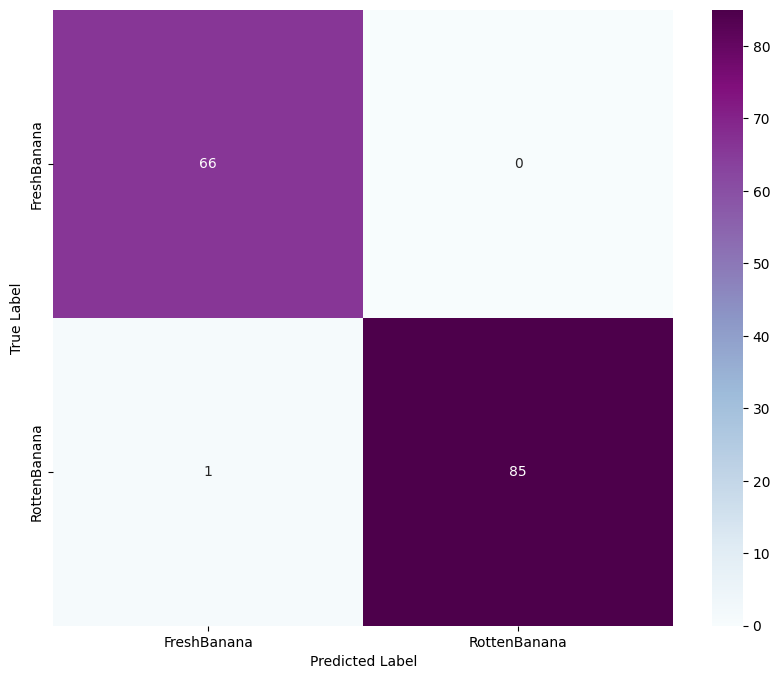

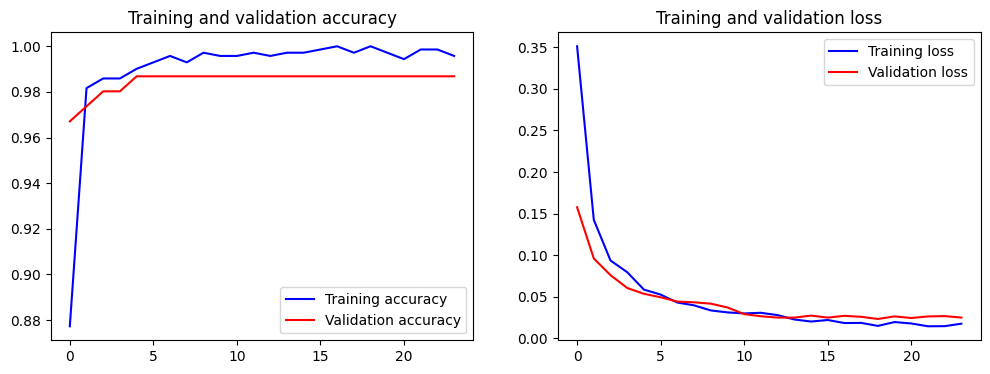

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)